In [1]:
import numpy as np
import torch
import torch.optim as optim

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

def rastrigin(A,x):
    n = x.shape[0]
    return A*n + x[0]**2 + x[1]**2 - A*torch.cos(2*np.pi*x[0]) - A*torch.cos(2*np.pi*x[1])




xmin, xmax, xstep = -5, 5, .1
ymin, ymax, ystep = -5, 5, .1
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = rastrigin(10,torch.tensor([x, y])).numpy()
              
z

array([[50.        , 50.91983006, 54.94983006, ..., 54.94983006,
        50.91983006, 50.        ],
       [50.91983006, 51.83966011, 55.86966011, ..., 55.86966011,
        51.83966011, 50.91983006],
       [54.94983006, 55.86966011, 59.89966011, ..., 59.89966011,
        55.86966011, 54.94983006],
       ...,
       [54.94983006, 55.86966011, 59.89966011, ..., 59.89966011,
        55.86966011, 54.94983006],
       [50.91983006, 51.83966011, 55.86966011, ..., 55.86966011,
        51.83966011, 50.91983006],
       [50.        , 50.91983006, 54.94983006, ..., 54.94983006,
        50.91983006, 50.        ]])

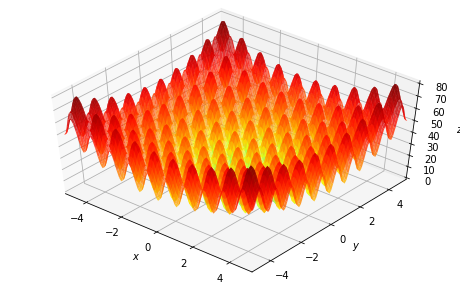

In [3]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)
ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()

In [4]:
xmin, xmax, xstep = -5.12, 5.12, .1
ymin, ymax, ystep = -5.12, 5.12, .1
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = rastrigin(10,torch.tensor([x, y])).numpy() #一次性计算二维平面上所有的点的值

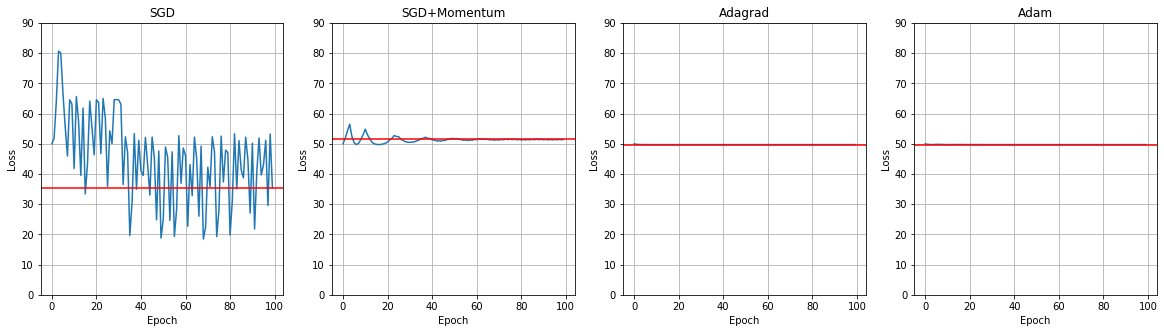

In [5]:
fig, ax = plt.subplots(ncols=4,figsize=(20,5))
p = torch.tensor([[5.0],[5.0]], requires_grad=True)
opts = [optim.SGD([p], lr=0.01),
       optim.SGD([p], lr=0.01,momentum = 0.9),
       optim.Adagrad([p], lr=0.01),
       optim.Adam([p], lr=0.01)]
names = ['SGD','SGD+Momentum','Adagrad','Adam']

j=0
for opt in opts:
    p.data = torch.tensor([[5.0],[5.0]])
    path = np.empty((2,0))
    path = np.append(path, p.data.numpy(), axis=1)
    lPlot = np.empty((1,0))
    for i in range(100):
        opt.zero_grad()
        output = rastrigin(10,p)
        output.backward()
        opt.step()
        path = np.append(path, p.data.numpy(), axis=1)
        lPlot = np.append(lPlot, output.data.numpy().reshape(1,-1), axis=1)
    ax[j].plot(range(100),lPlot.squeeze())#,label=str(opt)
    ax[j].set_title(names[j])
    ax[j].set_ylim(0,90)
    ax[j].grid(True)
    ax[j].set_ylabel("Loss")
    ax[j].set_xlabel("Epoch")
    ax[j].axhline(y=lPlot[:,-1].item(), color='r')
    j+=1
    


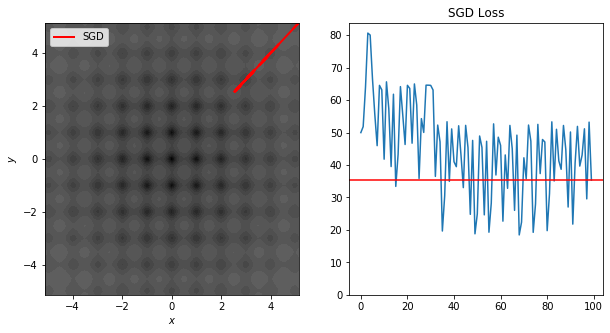

In [6]:
fig, ax = plt.subplots(ncols=2,figsize=(10, 5))
ax[0].contourf(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.gray)
p = torch.tensor([[5.0],[5.0]], requires_grad=True)

opt = optim.SGD([p], lr=0.01)#,momentum = 0.9)#), lr=0.3)#
path = np.empty((2,0))
path = np.append(path, p.data.numpy(), axis=1)
lPlot = np.empty((1,0))

for i in range(100):
    opt.zero_grad()
    output = rastrigin(10,p)
    output.backward()
    opt.step()
    path = np.append(path, p.data.numpy(), axis=1)
    lPlot = np.append(lPlot, output.data.numpy().reshape(1,-1), axis=1)

ax[0].plot(path[0], path[1], color='red', label='SGD', linewidth=2)
ax[0].legend()
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
ax[0].set_xlim((xmin, xmax))
ax[0].set_ylim((ymin, ymax))

ax[1].plot(range(100),lPlot.squeeze())
ax[1].set_ylim(0)
ax[1].set_title('SGD Loss')
ax[1].axhline(y=lPlot[:,-1].item(), color='r')


# SVM on Iris dataset

In [7]:
import pandas as pd
from torch.utils import data

df  =  pd.read_csv ('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

df = df.sample(frac=1,random_state=0)#shuffle
df = df[df[4].isin(['Iris-virginica', 'Iris-versicolor'])]#filter

#add label indices column
mapping = {k: v for v,k in enumerate(df[4].unique())}
df[5] = (2 * df[4].map(mapping)) - 1                


#normalise data
alldata = torch.tensor(df.iloc[:,[0,1,2,3]].values,dtype=torch.float)
alldata = (alldata - alldata.mean(dim=0))/alldata.var(dim=0)


#create datasets
targetstr=torch.tensor(df.iloc[:75,5].values,dtype=torch.long)
targetsva=torch.tensor(df.iloc[75:,5].values,dtype=torch.long)
datatr=alldata[:75]
datava=alldata[75:]


In [8]:
dataset = data.TensorDataset(datatr,targetstr) # create your datset
dataloader = data.DataLoader(dataset, batch_size=25, shuffle=False) # create your dataloader

In [9]:
def hinge_loss(y_pred, y_true):
    #当样本被正确分类且函数间隔大于1时，合页损失才是0，否则损失是1-y(wx+b)。
    length = y_pred.shape[0]
    q = torch.ones(length,1)
    m = q - y_true * y_pred
    p = torch.zeros(length, 1)
    loss = torch.max(p,m)
    return torch.mean(loss)

def svm(x, w, b):
    h = (w*x).sum(1) + b
    return h

In [10]:
def evaluate(data, w, b, targets):
    pred = svm(data,w,b)
    pred[np.where(pred >= 0)]=1
    pred[np.where(pred < 0)]=-1
    a = torch.eq(pred, targets, out=None)
    a = float(a.sum())/float(a.shape[0])
    #print('acc:',a)
    return a

tr  0.9066666666666666
va  0.88


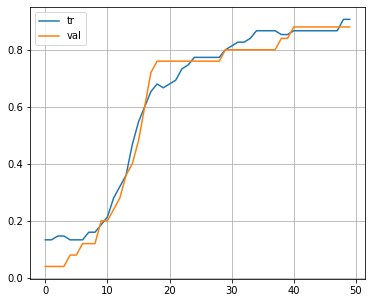

In [25]:
w = torch.randn(1, 4, requires_grad=True)
b = torch.randn(1, requires_grad=True)

opt = optim.SGD([w,b], lr=0.01, weight_decay=0.0001) #用优化器要记得梯度清零
trPlot = []
vaPlot = []
for epoch in range(50):
    for batch in dataloader:
          opt.zero_grad()
          data,target = batch
          svm_re = svm(data,w,b)
          output = hinge_loss(svm_re, target)
          output.backward()
          opt.step()
    trPlot.append(evaluate(datatr, w, b, targetstr))
    vaPlot.append(evaluate(datava, w, b, targetsva))
    


print('tr ',evaluate(datatr, w, b, targetstr))
print('va ',evaluate(datava, w, b, targetsva))
fig,ax = plt.subplots(figsize=(6,5))
ax.plot(range(50),trPlot,label='tr'),ax.plot(range(50),vaPlot,label='val')
ax.legend()
ax.grid(True)